**Objective: Model Development for Missing Value Prediction in 'Energy Consumption'**

This notebook aims to predict missing values in energy consumption data using a Decision Tree Regressor. The process involves comprehensive data analysis, preprocessing, model training, and predictions.

**Steps:**

1. **Data Loading:**
   - Imported two datasets, 'energy_df' and 'household_df.'
   - Explored the structure and content of the datasets.

2. **Data Transformation:**
   - Melted the datasets for better analysis and merged them based on common columns.

3. **Data Refinement:**
   - Renamed and filtered columns for clarity and relevance.
   - Defined functions to streamline data transformation and filtering.

4. **Model Training (Comparison):**
   - Trained a Linear Regression model and a Decision Tree Regressor on a subset of data.
   - Evaluated model performance using R-squared and RMSE metrics.

5. **Prediction of Missing Values:**
   - Scaled features and target variable for training using PowerTransformer.
   - Trained a Decision Tree Regressor on the entire dataset.
   - Predicted missing values in 'energy_consumption' for a subset of data.

6. **Data Integration:**
   - Merged predicted values into the original dataset, filling missing data.

**Conclusion:**
## Exploratory Data Analysis
### Missing Values in 'Energy Consumption'
- Country-Wise Pattern: Cyprus, Ukraine, EA20, and EU27_2020 consistently exhibit high missing values (2012-2021).
- Yearly Trend: General decrease from 2012 to 2017; slight uptick in 2020-2021.
- Energy Use Type: Missing values uniformly distributed across types.

#### 'Energy Consumption' Distribution by Country, Year, and Energy Use Type
- Country-wise Distribution: EU27_2020, EA20 show higher consumption; individual nations vary.
- Yearly Trends: Potential overall increase from 2012 to 2021.
- Energy Use Type: 'h_energy_use' indicates highest consumption; specific types vary.

### Trend Count of Missing Values for 'Energy Consumption'
Shows count of missing values across countries (2012-2021).
Certain countries consistently show missing values; potential pattern related to specific countries and years.

### Modeling
- Acknowledged model simplicity and suggested improvements with more data analysis.
- Cautioned about limited features' impact on results.

**Regression Models Analysis:**
Linear Regression explains ~25.4%, while Decision Tree Regressor performs significantly better with 96% R-squared and low RMSE (0.195). Caution: Limited features used; further analysis and feature selection recommended.

### The two Dataset used Information
| Dataset | Disaggregated Final Energy Consumption in Households - Quantities |
| --- | --- |
| Source | Eurostat |
| Description | Filtered energy balance records for various sectors and energy uses in households across specific countries and years. |
| Data Categories | - Final consumption - other sectors - households - energy use [FC_OTH_HH_E] - Final consumption - other sectors - households - energy use - space heating [FC_OTH_HH_E_SH] - Final consumption - other sectors - households - energy use - space cooling [FC_OTH_HH_E_SC] - Final consumption - other sectors - households - energy use - water heating [FC_OTH_HH_E_WH] - Final consumption - other sectors - households - energy use - cooking [FC_OTH_HH_E_CK] |
| Countries | - Total: 37 specific countries - European Union - 27 countries (from 2020) [EU27_2020] - Euro area – 20 countries (from 2023) [EA20] |
| International Energy Product Classifications | - Total [TOTAL] |
| Time Period | 2012 to 2021 |
| Time Frequency | Annual |
| Unit of Measure | Terajoule (10^12 joules; about 0.278 GWh) |

[Energy Dataset Source](https://ec.europa.eu/eurostat/databrowser/view/NRG_D_HHQ/default/table?lang=en)

---

| Dataset | Number of Households by Household Composition, Number of Children, and Age of Youngest Child (1,000) |
| --- | --- |
| Purpose | Additional data used to aid prediction |
| Countries | EU Countries |
| Age of a Child | [agechild] - Total [TOTAL] |
| Number of Children | n_child - Total [TOTAL] |
| Household Composition | [hhcomp] - Total [TOTAL] |
| Time Period | 2012 to 2021 |
| Time Frequency | Annual |
| Unit of Measure | Thousand Households [THS_HH] |

[Number of Household Dataset Source](https://ec.europa.eu/eurostat/databrowser/view/LFST_HHNHTYCH/default/table?lang=en)

In [34]:
# Importing necessary Libraries
import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import missingno as msno
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score,mean_squared_error

# Dictionaries to match country name and Energy use types
from eurostat_dictionary import country_dictionary, energy_types_dict
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')
# plt.style.available

sys.path.append("C:\\Users\\Biniam\\Desktop\\energy_api\\src")

#### Loading the dataset
- Data Overview
    - View the first 5 rows of Original Dataset

In [35]:
# Importing data from Eurostat using `eurostat.get_data_df` Python library
energy_df = eurostat.get_data_df('nrg_d_hhq')
# Original dataset
energy_df.head(5)

,freq,nrg_bal,siec,unit,geo\TIME_PERIOD,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,A,FC_OTH_HH_E,E7000,GWH,AL,2997.450,2936.634,3065.799,4066.970,3500.001,3240.375,2990.930,2934.535,3146.976,3120.242,3469.079,3504.652
1,A,FC_OTH_HH_E,E7000,GWH,AT,17657.493,17273.639,17541.316,17649.164,16815.552,17215.299,17838.838,17998.218,17942.604,18336.543,18006.175,20283.197
2,A,FC_OTH_HH_E,E7000,GWH,BA,NaN,NaN,NaN,NaN,4604.000,4725.000,4734.000,4755.000,4685.000,4725.999,4795.000,4912.000
3,A,FC_OTH_HH_E,E7000,GWH,BE,NaN,NaN,NaN,NaN,NaN,NaN,18849.100,18537.100,18508.100,18357.200,18663.200,19267.500
4,A,FC_OTH_HH_E,E7000,GWH,BG,10559.000,10912.000,10838.000,10537.000,10590.000,10644.000,10733.000,11137.538,10963.025,10843.892,11356.181,11953.294


In [36]:
household_df = eurostat.get_data_df('lfst_hhnhtych')
household_df.head()

,freq,agechild,n_child,hhcomp,unit,geo\TIME_PERIOD,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,NAP,0,HHC_20,THS_HH,AT,1220.0,1241.6,1260.0,1279.3,...,1367.7,1396.5,1419.0,1430.6,1439.5,1457.7,1481.5,1506.4,1561.6,1587.3
1,A,NAP,0,HHC_20,THS_HH,BE,1341.3,1302.4,1376.6,1396.2,...,1350.8,1315.2,1380.1,1353.5,1523.6,1501.0,1460.0,1570.3,1787.2,1865.5
2,A,NAP,0,HHC_20,THS_HH,BG,726.9,757.6,778.0,822.1,...,710.0,731.7,1051.7,781.5,1086.6,847.7,859.2,861.3,945.7,984.3
3,A,NAP,0,HHC_20,THS_HH,CY,37.7,39.8,38.3,38.8,...,53.2,58.0,62.7,73.9,77.9,81.5,82.7,81.2,86.1,90.4
4,A,NAP,0,HHC_20,THS_HH,CZ,1053.9,1105.4,1172.2,1180.4,...,1299.2,1382.9,1387.2,1427.7,1445.9,1521.5,1550.5,1583.3,1645.7,1631.7


### Prepare data for analysis

In [37]:
def melt_and_sort(df, id_vars, value_vars, value_name, sort_by):
    melted_df = pd.melt(
        df,
        id_vars=id_vars,
        var_name='year', 
        value_name=value_name
    )

    melted_df['year'] = melted_df['year'].astype(int)
    melted_df = melted_df.sort_values(by=sort_by)
    
    return melted_df

# Perform melt and sort for the energy DataFrame
energy_df_melted = melt_and_sort(
    energy_df,
    id_vars=['freq', 'nrg_bal', 'siec', 'unit', 'geo\TIME_PERIOD'],
    value_vars=None,  # If all columns need to be melted
    value_name='energy_consumption',
    sort_by=['geo\TIME_PERIOD', 'year']
)

# Perform melt and sort for the household DataFrame
household_melted_df = melt_and_sort(
    household_df,
    id_vars=['freq', 'agechild', 'n_child', 'hhcomp', 'unit', 'geo\TIME_PERIOD'],
    value_vars=None,  # If all columns need to be melted
    value_name='number_of_households',
    sort_by=['geo\TIME_PERIOD', 'year']
)

# Merge the datasets on common columns 'freq', 'geo\TIME_PERIOD', and 'year'
merged_df = pd.merge(energy_df_melted, household_melted_df, on=['freq', 'geo\TIME_PERIOD', 'year'])


In [38]:
def rename_columns(df):
    # Rename specific columns
    df.rename(columns={'geo\TIME_PERIOD': 'geo', 'siec': 'energy_types'}, inplace=True)
    
    # Map 'geo' to 'country' using a dictionary
    df['country'] = df['geo'].replace(country_dictionary)
    
    # Map 'nrg_bal' to 'energy_use_types' using a dictionary
    df['energy_use_types'] = df['nrg_bal'].replace(energy_types_dict)
    
    # Rename unit columns
    df.rename(columns={'unit_x': 'energy_unit', 'unit_y': 'household_unit'}, inplace=True)
    # Drop unnecessary columns
    df.drop(['nrg_bal', 'geo', 'freq'], inplace=True, axis=1)
    
    return df

def filter_data(df):
    # Define a list of relevant energy use types
    energy_use_types = ['h_energy_use', 'h_cooking', 'h_space_heating', 'h_water_heating', 'h_space_cooling']
    
    # Filter DataFrame based on energy use types
    filtered_df = df[df['energy_use_types'].isin(energy_use_types)]
    
    # Filter DataFrame based on the year range
    filtered_df = filtered_df[(filtered_df['year'] >= 2012) & (filtered_df['year'] <= 2021)]
    
    # Filter DataFrame based on energy types containing 'TOTAL' (case-insensitive)
    filtered_df = filtered_df[filtered_df['energy_types'].str.contains('TOTAL', case=False)].reset_index(drop=True)
    
    # Filter DataFrame based on 'agechild' containing 'TOTAL' (case-insensitive)
    filtered_df = filtered_df[filtered_df['agechild'].str.contains('TOTAL', case=False)].reset_index(drop=True)
    
    # Filter DataFrame based on 'hhcomp' containing 'TOTAL' (case-insensitive)
    filtered_df = filtered_df[filtered_df['hhcomp'].str.contains('TOTAL', case=False)].reset_index(drop=True)
    
    # Filter DataFrame based on 'n_child' containing 'TOTAL' (case-insensitive)
    filtered_df = filtered_df[filtered_df['n_child'].str.contains('TOTAL', case=False)].reset_index(drop=True)
    
    return filtered_df

# Apply the column renaming and data filtering functions
merged_df = rename_columns(merged_df)
filtered_df = filter_data(merged_df)


In [39]:
# Check the data types of the columns for the dataset
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   energy_types          1610 non-null   object 
 1   energy_unit           1610 non-null   object 
 2   year                  1610 non-null   int32  
 3   energy_consumption    1293 non-null   float64
 4   agechild              1610 non-null   object 
 5   n_child               1610 non-null   object 
 6   hhcomp                1610 non-null   object 
 7   household_unit        1610 non-null   object 
 8   number_of_households  1552 non-null   float64
 9   country               1610 non-null   object 
 10  energy_use_types      1610 non-null   object 
dtypes: float64(2), int32(1), object(8)
memory usage: 132.2+ KB


#### Validating each categorical variable

- Count of variables seem fairly balance across each variable which is good for our prediction

In [40]:
# Making a list of all catrgorical variables 
cat_col=['country', 'energy_types', 'energy_use_types']

# Printing number of count of each unique value in each column
for column in cat_col:
 print(filtered_df[column].value_counts(dropna=False))
 print('-'*50)

country
Austria            50
Hungary            50
Romania            50
Portugal           50
Poland             50
Norway             50
Netherlands        50
Malta              50
North Macedonia    50
Latvia             50
Luxembourg         50
Lithuania          50
Italy              50
Belgium            50
Croatia            50
Sweden             50
France             50
Finland            50
EU27_2020          50
Spain              50
Greece             50
Slovenia           50
EA20               50
Slovakia           50
Germany            50
Czechia            50
Cyprus             50
Bulgaria           50
Serbia             50
Ireland            40
Estonia            40
Denmark            40
United Kingdom     40
Name: count, dtype: int64
--------------------------------------------------
energy_types
TOTAL    1610
Name: count, dtype: int64
--------------------------------------------------
energy_use_types
h_energy_use       330
h_cooking          330
h_space_heating    330

In [41]:
def uniqueness(df):
    """"Calculates the number of unique values, the actual unique values, and the variable type of each column in a given pandas DataFrame.
    """
    variables = pd.DataFrame(columns=['Variable','Number of unique values','Values', 'Variable types'])

    for i, var in enumerate(df.columns):
        variables.loc[i] = [var, df[var].nunique(),df[var].unique().tolist(), df[var].dtype]
    variables.set_index('Variable', inplace=True)    
    return variables.sort_values('Number of unique values', ascending=False)
uniqueness(filtered_df)

,Number of unique values,Values,Variable types
Variable,,,
energy_consumption,1260,"[279812.575, 7026.769, 34.214, 195419.282, 418...",float64
number_of_households,314,"[3685.0, 3721.5, 3768.2, 3815.9, 3864.0, 3889....",float64
country,33,"[Austria, Belgium, Bulgaria, Cyprus, Czechia, ...",object
year,10,"[2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...",int32
energy_use_types,5,"[h_energy_use, h_cooking, h_space_cooling, h_s...",object
energy_types,1,[TOTAL],object
energy_unit,1,[TJ],object
agechild,1,[TOTAL],object
n_child,1,[TOTAL],object


#### Validating numerical values 

In [42]:
# Validate any negative values in numeric variables
filtered_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1610.0,2016.500000,2.873174,2012.0,2014.000,2016.500,2019.000,2.021000e+03
energy_consumption,1293.0,258295.359983,935733.740837,0.0,4176.925,32276.224,142929.777,1.095386e+07
number_of_households,1552.0,17894.604704,41838.440822,153.8,1460.900,4012.500,7936.100,1.968580e+05


#### Checking for Missing Values
-  energy_consumption and number_of_households have missing values, with energy_consumption having a higher percentage of missing entries compared to the rest. Other columns seem to have no missing data.

In [43]:
def missing_data_percentage(df):
    """
    Calculates the percentage of missing values in each column of a given pandas DataFrame and displays the result.
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, round(percent,2)], axis=1, keys=['Total', 'Percent'])
    return display(missing_data)
missing_data_percentage(filtered_df)

,Total,Percent
energy_consumption,317,0.20
number_of_households,58,0.04
energy_types,0,0.00
energy_unit,0,0.00
year,0,0.00
agechild,0,0.00
n_child,0,0.00
hhcomp,0,0.00
household_unit,0,0.00
country,0,0.00


#### No duplication in the dataset

In [44]:
duplicate_rows = filtered_df[filtered_df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows.shape[0])

Number of duplicate rows:  0


### Dealing with number_of_households missing value 
Since the missing values for number_of_households are less than 5% (0.04) and looking at the distribution, it seems that the missing values are random, so we are going to use simple Imputation techniques like median

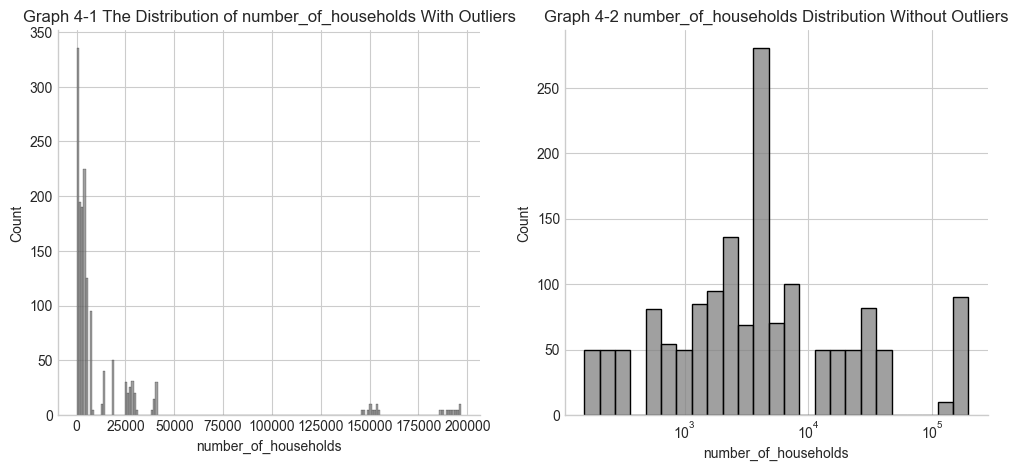

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
ax = sns.histplot(data=filtered_df, x='number_of_households', ax=axes[0], color='gray')
axes[0].set(title='Graph 4-1 The Distribution of number_of_households With Outliers')

sns.histplot(data=filtered_df, x='number_of_households', log_scale=True, ax=axes[1], color='gray')
axes[1].set_title('Graph 4-2 number_of_households Distribution Without Outliers')
sns.despine(right=True)
plt.show()


In [46]:
# Imputing Number of household missing values with Median
filtered_df['number_of_households'].fillna(filtered_df['number_of_households'].median(), inplace=True)

In [47]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   energy_types          1610 non-null   object 
 1   energy_unit           1610 non-null   object 
 2   year                  1610 non-null   int32  
 3   energy_consumption    1293 non-null   float64
 4   agechild              1610 non-null   object 
 5   n_child               1610 non-null   object 
 6   hhcomp                1610 non-null   object 
 7   household_unit        1610 non-null   object 
 8   number_of_households  1610 non-null   float64
 9   country               1610 non-null   object 
 10  energy_use_types      1610 non-null   object 
dtypes: float64(2), int32(1), object(8)
memory usage: 132.2+ KB


## Exploratory Data Analysis (EDA)
### Investigating Missing Values in the 'Energy Consumption' Target Variable
Is there a pattern in the missing values?
1. Country-Wise Pattern: Certain countries consistently exhibit high missing values, such as Cyprus, Ukraine, EA20, and EU27_2020, across the entire timeframe (2012 to 2021).
2. Yearly Trend: There's a general decreasing trend in missing values from 2012 to 2017. However, in 2020 and 2021, there's a slight deviation from this trend, with a slight uptick in missing values compared to the preceding years.
3. Energy Use Type: The missing values seem uniformly distributed across different energy use types, indicating no specific bias towards any particular type.

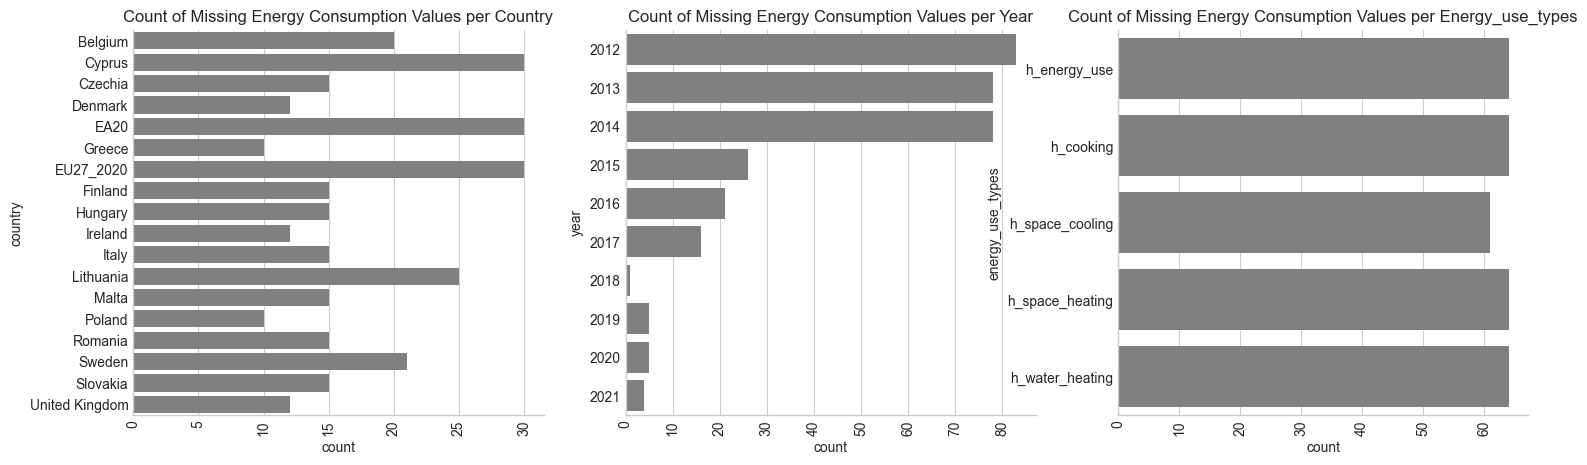

In [48]:
# Filtering rows with missing 'Energy Consumption' values
missing_energy_consumption = filtered_df[filtered_df['energy_consumption'].isnull()]

fig, axes = plt.subplots(1,3,figsize=(18,5))
sns.countplot(y=missing_energy_consumption['country'],color='gray',ax=axes[0]).set(title='Count of Missing Energy Consumption Values per Country')
sns.countplot(y=missing_energy_consumption['year'],color='gray',ax=axes[1]).set(title='Count of Missing Energy Consumption Values per Year')
sns.countplot(y=missing_energy_consumption['energy_use_types'],color='gray',ax=axes[2]).set(title='Count of Missing Energy Consumption Values per Energy_use_types')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
sns.despine(right=True)
plt.show()

### IS there apparent trend count of missing values for 'Energy Consumption' grouped by country and year.
This table seems to show the count of missing values in 'Energy Consumption' across different countries from 2012 to 2021. 
There's an apparent trend where certain countries have consistent missing values in specific years. For example, 'EU27_2020' and 'EA20' consistently show missing values across all years, while other countries like 'Denmark' or 'United Kingdom' started with missing values that gradually decreased over time. This suggests a potential pattern in missing data distribution related to specific countries and years.

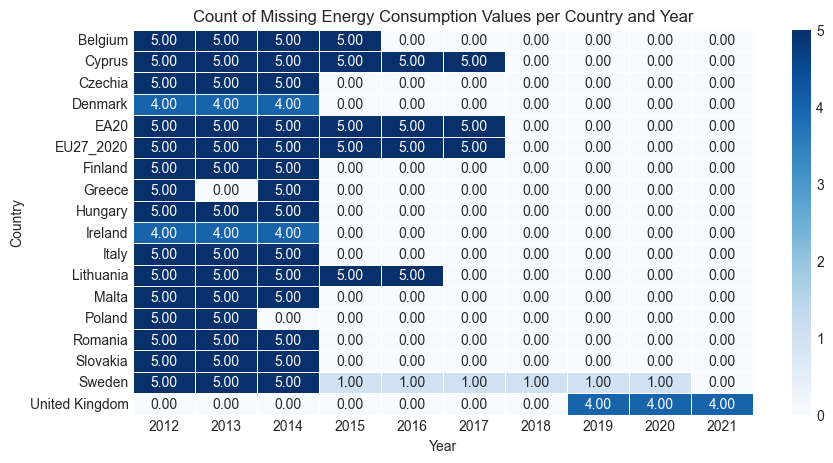

In [49]:
missing_count = missing_energy_consumption.groupby(['country', 'year']).size().reset_index(name='missing_count')
pivot_table = missing_count.pivot_table(index='country', columns='year', values='missing_count', fill_value=0)

pivot_table = pivot_table.round(2)
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Blues', linewidths=0.5)
plt.title('Count of Missing Energy Consumption Values per Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

#### The 'Energy Consumption' distribution, excluding missing values:
Original 'Energy Consumption' Distribution:
- Positively skewed, with most values below 120,000 and some exceptionally high values up to approximately 10,953,860 (Total joules).
- Histogram showing clustering towards the lower end and highlighting a few extremely high values as outliers.

Log Transformed 'Energy Consumption' (log Energy Consumption):
- Used to deal with skewness and compress the scale for a more normalized view.
- Also provides a different perspective on the distribution, potentially reducing the impact of extreme values and making the distribution more symmetric or easier to analyze.

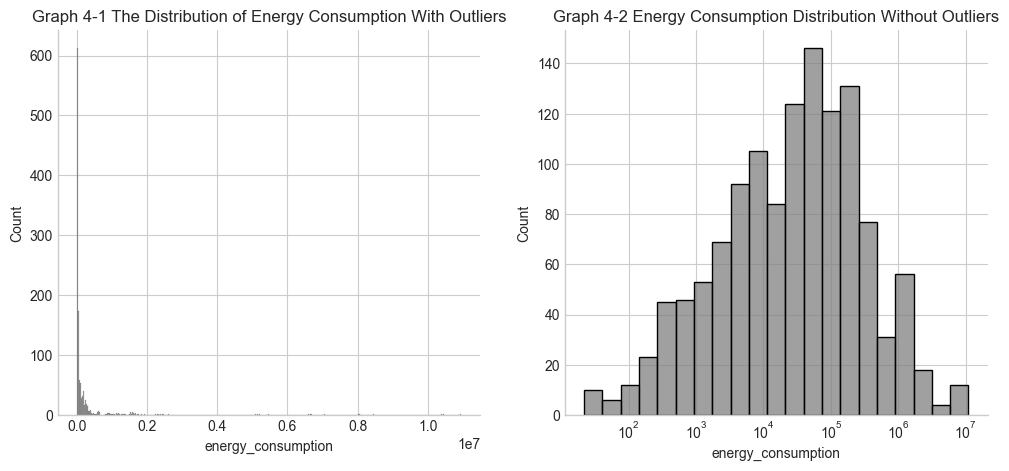

In [50]:
non_missing_df = filtered_df.dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
ax = sns.histplot(data=non_missing_df, x='energy_consumption', ax=axes[0], color='gray')
axes[0].set(title='Graph 4-1 The Distribution of Energy Consumption With Outliers')

sns.histplot(data=non_missing_df, x='energy_consumption', log_scale=True, ax=axes[1], color='gray')
axes[1].set_title('Graph 4-2 Energy Consumption Distribution Without Outliers')
sns.despine(right=True)
plt.show()

#### Relationship Between 'Energy Consumption' Distribution and Country, Year, and Energy Use Type
How does Energy Consumption in relation to Country, Year and Energy Use Type look like?
- Country-wise Distribution: 
    Larger groups of countries, like EU27_2020 and EA20, tend to showcase higher average energy consumption. On the other hand, individual nations exhibit varying levels of energy usage, with some displaying comparatively lower consumption rates. This disparity between broader country groups and individual nations could be pivotal in predicting missing energy values.

- Yearly Trends: 
    Average 'Energy Consumption' values suggest a potential overall increase from 2012 to 2021. The trend indicates a rise in energy usage over time, with 2021 showing the highest average consumption and 2017 the lowest.

- Energy Use Type: 
    Differentiating energy consumption based on 'Energy Use Types' highlights significant disparities. 'h_energy_use' indicates the highest energy consumption, likely encompassing broader usage categories. In contrast, specific types like 'h_space_cooling' exhibit notably lower consumption levels.

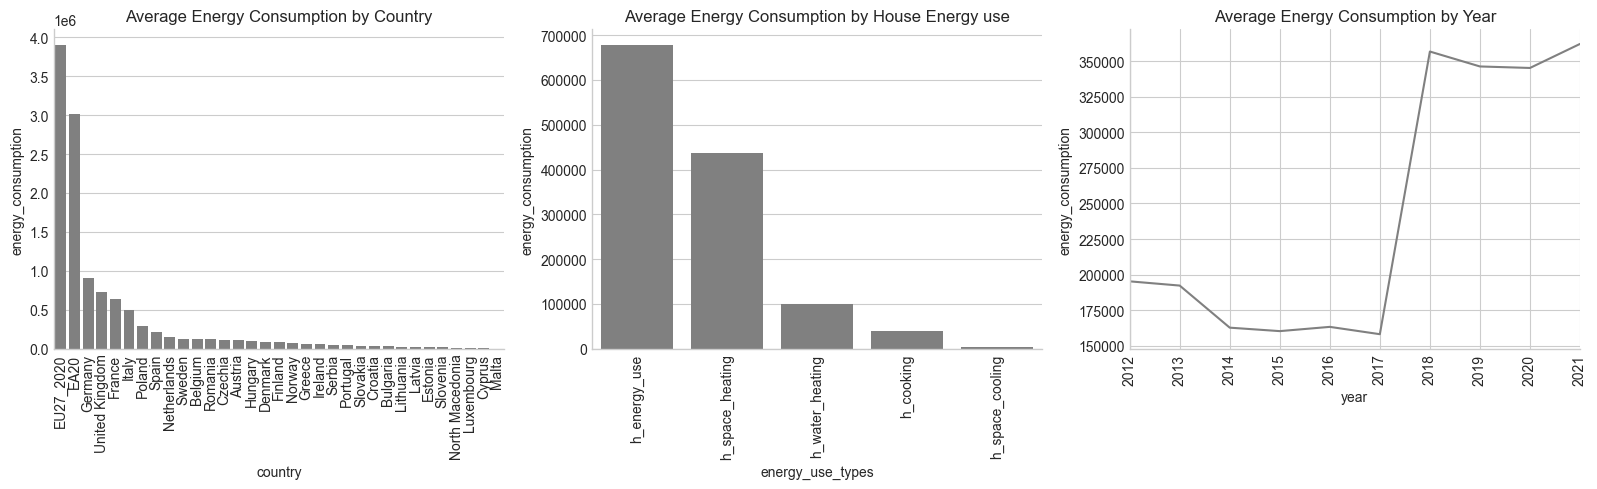

In [51]:
# Calculate average Energy Consumption per country, year and energy_use_types
average_energy_consumption_by_country = non_missing_df.groupby('country')['energy_consumption'].mean().reset_index().sort_values('energy_consumption', ascending=False)
average_energy_consumption_by_year = non_missing_df.groupby('year')['energy_consumption'].mean().reset_index().sort_values('energy_consumption', ascending=False)
average_energy_consumption_by_energy_use_types = non_missing_df.groupby('energy_use_types')['energy_consumption'].mean().reset_index().sort_values('energy_consumption', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.barplot(data=average_energy_consumption_by_country, x='country', y='energy_consumption', order=average_energy_consumption_by_country['country'], ax=axes[0], color='gray').set(title='Average Energy Consumption by Country')
sns.barplot(data=average_energy_consumption_by_energy_use_types, x='energy_use_types', y='energy_consumption', order=average_energy_consumption_by_energy_use_types['energy_use_types'], color='gray', ax=axes[1]).set(title='Average Energy Consumption by House Energy use')
sns.lineplot(data=average_energy_consumption_by_year, x='year', y='energy_consumption', ax=axes[2], color='gray').set(title='Average Energy Consumption by Year')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    
sns.despine(right=True)
plt.xlim(average_energy_consumption_by_year['year'].min(), average_energy_consumption_by_year['year'].max())
plt.tight_layout()
plt.show()


### Correlation Heatmap
Energy_consumption and number_of_households display a moderate positive correlation of about 0.66, indicating a tendency for higher energy consumption in areas with more households.
Considering the weak correlation of 'year' with other variables, it might be beneficial to treat 'year' as a categorical.

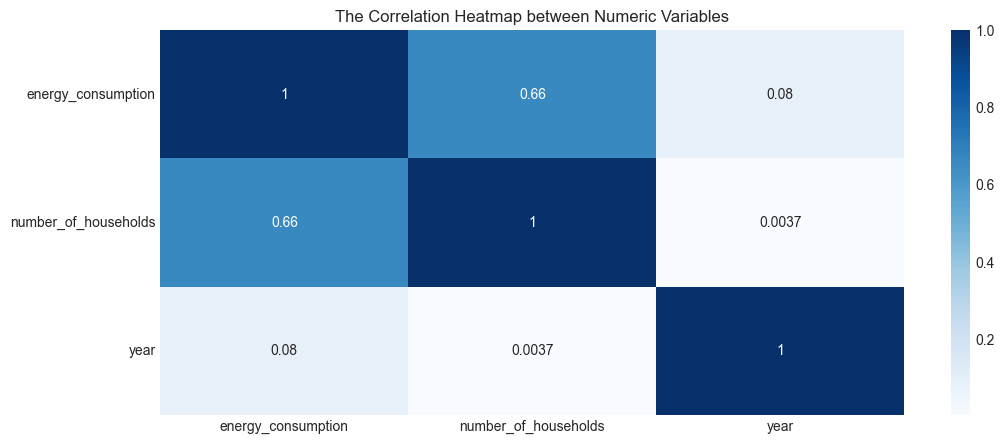

In [52]:
numeric = filtered_df[['energy_consumption','number_of_households','year']]
plt.figure(figsize=(12, 5))
sns.heatmap(numeric.corr(),annot=True, cmap='Blues').set(title='The Correlation Heatmap between Numeric Variables')
plt.show()

### Data preparation for model

To enable modelling, we chose year,model,transmission,mileage,fuelType,tax,engineSize as features, energy_consumption as target variables. Made the following changes:

- Normalize the numeric features including target variable since its skewed
- Convert the categorical variables into numeric features
- Split the data into a training set and a test set

In [53]:
# Take out the missing values from the filtered dataset and use them for training models.
train_data = filtered_df.dropna(subset=['energy_consumption'])  # Rows with non-missing 'energy_consumption'

# Scale energy_consumption
tscale = PowerTransformer()
train_data['energy_consumption'] = tscale.fit_transform(train_data[['energy_consumption']])


# Selecting rows with missing values in the 'energy_consumption' column for prediction
missing_values_to_predict = filtered_df[filtered_df['energy_consumption'].isnull()]

# Convert categorical features to numeric using LabelEncoder
labelencoder = LabelEncoder()
train_data['country'] = labelencoder.fit_transform(train_data['country'])
train_data['energy_use_types'] = labelencoder.fit_transform(train_data['energy_use_types'])
train_data['year'] = train_data['year'].astype('category')

# Scale numerical features using PowerTransformer including target variable
scaler = PowerTransformer()
numerical_features = ['country', 'number_of_households', 'energy_use_types']
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Selecting relevant features for prediction
features = ['country', 'number_of_households', 'year', 'energy_use_types']

# Splitting features and target variable for train_data
X = train_data[features]
y = train_data['energy_consumption']

# Split train_data into 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of training and testing sets from train_data
print('Training set:', X_train.shape, 'Test set:', y_train.shape)
print('Testing set:', X_test.shape, 'Test set:', y_test.shape)


Training set: (1034, 4) Test set: (1034,)
Testing set: (259, 4) Test set: (259,)


#### Linear Regression Model

In [54]:
# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set from train_data
y_pred = model.predict(X_test)

# Evaluate the performance of the Linear Regression model on train_data
print('Linear Regression Test r2_score:', r2_score(y_test, y_pred))
print('Linear Regression Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Linear Regression Test r2_score: 0.25397920134010055
Linear Regression Test Root Mean Squared Error: 0.8440258077685652


#### Feature importance

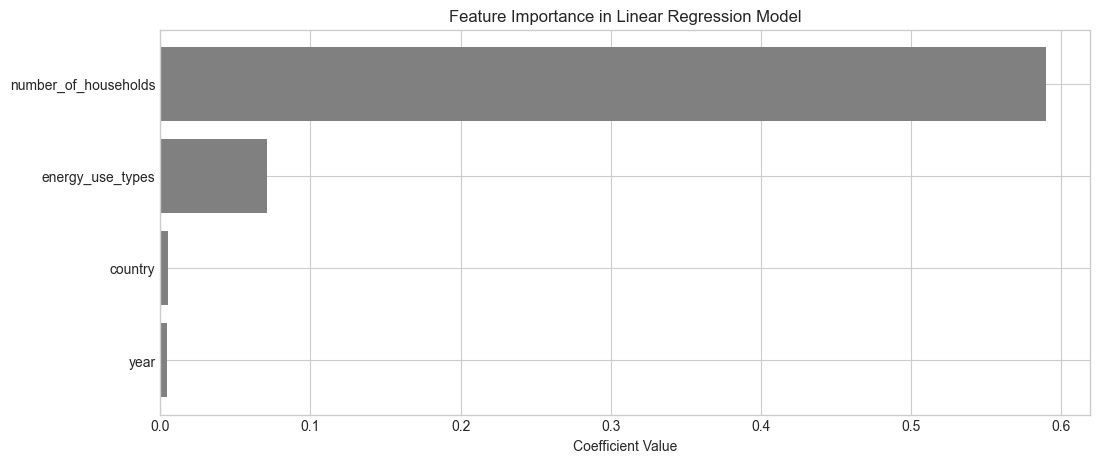

In [55]:
resultdict = {}
for i in range(len(features)):
    resultdict[features[i]] = model.coef_[i]

# Sorting the dictionary by values
sorted_resultdict = dict(sorted(resultdict.items(), key=lambda item: item[1]))

plt.figure(figsize=(12, 5))  # Adjust the figure size
plt.barh(list(sorted_resultdict.keys()), list(sorted_resultdict.values()), color='gray')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression Model')
plt.show()

 ## Decision Tree Regression Model

In [56]:
# Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=11, min_samples_split=2, random_state=42)
tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred2 = tree.predict(X_test)

# Evaluate the performance of the Decision Tree Regressor on train_data
d_r2 = tree.score(X_test, y_test)
print("Decision Tree Regressor R-squared:", d_r2)

d_mse = mean_squared_error(y_pred2, y_test)
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE:", d_rmse)

Decision Tree Regressor R-squared: 0.9601943807844626
Decision Tree Regressor RMSE: 0.19496311295711968


### Finding the best parameter for Decision Tree Regression Model

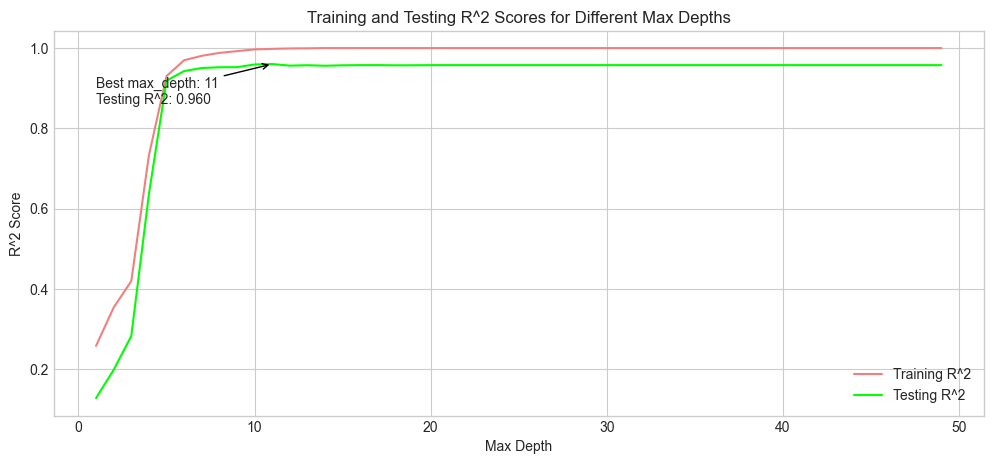

In [57]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    train_score.append(tree.score(X_train,y_train))
    test_score.append(r2_score(y_test,y_pred))
    test_pair = (i,r2_score(y_test,y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots(figsize=(12, 5))  # Adjust the figure size
ax.plot(np.arange(1, 50), train_score, label="Training R^2", color='lightcoral')
ax.plot(np.arange(1, 50), test_score, label="Testing R^2", color='lime')
ax.set_xlabel('Max Depth')
ax.set_ylabel('R^2 Score')
ax.set_title('Training and Testing R^2 Scores for Different Max Depths')
ax.legend()
max_depth, test_r2 = max_pair  # Unpack max_depth and test R^2 score from max_pair
ax.annotate(f'Best max_depth: {max_depth}\nTesting R^2: {test_r2:.3f}', 
            xy=(max_depth, test_r2), 
            xytext=(max_depth - 10, test_r2 - 0.1),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10)
plt.show()


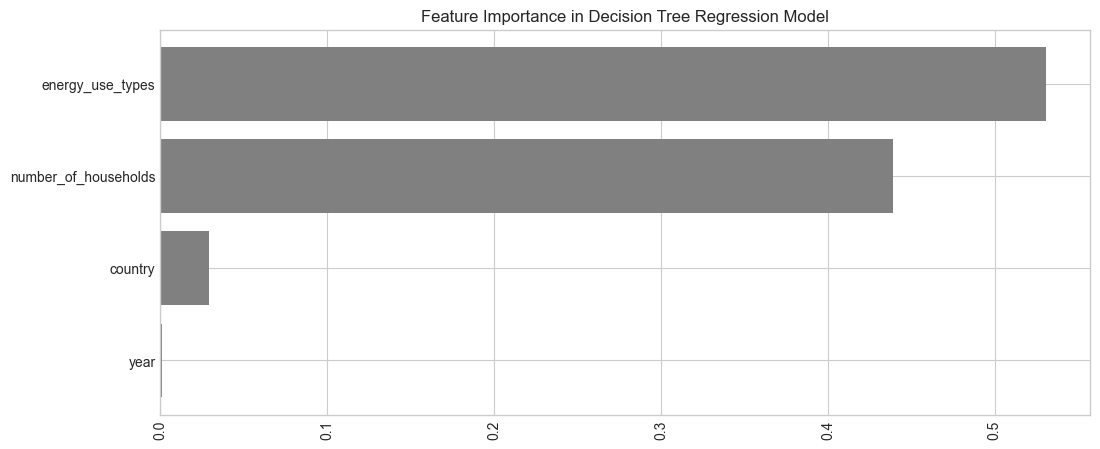

In [58]:
importance = tree.feature_importances_

f_importance = {}
for i in range(len(features)):
     f_importance[features[i]] = importance[i]
     
f_importance = dict(sorted(f_importance.items(), key=lambda item: item[1]))

plt.figure(figsize=(12, 5))
plt.barh(list(f_importance.keys()), list(f_importance.values()), color='gray')
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Decision Tree Regression Model')
plt.show()

### Finally, we train the DecisionTreeRegressor model on the entire dataset and utilize its predictions to fill in the missing data.

In [59]:
# Initialize the Decision Tree Regressor model for final prediction
final_tree_model = DecisionTreeRegressor(max_depth=11, min_samples_split=2, random_state=42)

# Train the model on the entire training data
final_tree_model.fit(X, y)

# Select relevant features for prediction on missing values
selected_features_missing_values = missing_values_to_predict[features]

# Convert categorical features to numeric using LabelEncoder for prediction data
label_encoder = LabelEncoder()
selected_features_missing_values['country'] = label_encoder.fit_transform(selected_features_missing_values['country'])
selected_features_missing_values['energy_use_types'] = label_encoder.fit_transform(selected_features_missing_values['energy_use_types'])
selected_features_missing_values['year'] = selected_features_missing_values['year'].astype('category')

# Scale numerical features using the same scaler that was fit on the training data
selected_features_missing_values[numerical_features] = scaler.transform(
    selected_features_missing_values[numerical_features]
)

# Use the trained model to predict the missing values in the 'energy_consumption' column
missing_values_predictions_scaled = final_tree_model.predict(selected_features_missing_values)

# Inverse transform the scaled predictions to the original scale using target scaler
missing_values_predictions_original_scale = tscale.inverse_transform(
    missing_values_predictions_scaled.reshape(-1, 1)
)

# Assign the unscaled predictions to the missing values prediction
missing_values_to_predict['energy_consumption'] = missing_values_predictions_original_scale

# Filling the missing data using common index in both DataFrames for the final dataset.
filtered_df.loc[missing_values_to_predict.index, 'energy_consumption'] = missing_values_to_predict['energy_consumption'].values

### Preliminary Analysis of Regression Models: Insights, Recommendations, and Future Directions

We employed simple regression models, namely Linear Regression and Decision Tree Regressor, for a preliminary comparison on our dataset. The results indicate that while the Linear Regression model explains about `25.4%` of the variance in the target variable, the Decision Tree Regressor performs significantly better with an R-squared value of `96%` and a low Root Mean Squared Error (RMSE) of 0.195.

Since we utilized a limited number of features from our two datasets, it's essential to approach these results with caution. This preliminary analysis serves as an initial exploration, highlighting the potential for improvement with more in-depth analysis and feature selection. We recommend further investigation into the additional data, exploring additional relevant features, and conducting a more comprehensive analysis. The current models provide a starting point, and with more time and detailed analysis, we can enhance the accuracy and robustness of our predictive models